In [42]:
# Import libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image as PImage
import glob
import shutil
import math

cudnn.benchmark = True
plt.ion() 
CUDA_LAUNCH_BLOCKING=1

~~~Split data to train, validation and testing sets

In [44]:
src_dir = './Food/food-101/images/'
list_dir = ['./train/','./val/','./test/']

def copy_imgs(src_dir, folder, list_dir, list_img):
    for each_dir in list_dir:
        for imgs in list_img:
            for x in imgs:
                shutil.copy(src_dir + folder + '/' + x, each_dir +folder)

def create_dir(list_dir):
    # Check whether the specified path exists or not
    for each_dir in list_dir:
        isExist = os.path.exists(each_dir)
        if not isExist:
            os.mkdir(each_dir)

create_dir(list_dir)
   
lists = os.listdir('./Food/food-101/images/') 

for folder in lists[:10]:
    directory = src_dir+folder+'/'
    
    class_dir = [x+folder+'/' for x in list_dir]
    create_dir(class_dir)
    
    list_img = os.listdir(directory)
    
    ### Change to 70%, 20% and 10% for train, val and test sets
    folds = [list_img[:30], list_img[30:40], list_img[40:50]]
    copy_imgs(src_dir, folder, list_dir, folds)
    print("Done!")

In [53]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '.'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
    print("Cuda available")
else:
    print("CPU available")
print("Done!")

CPU available
Done!


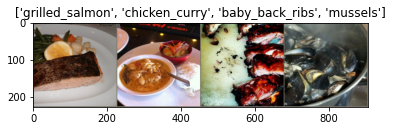

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [49]:
model_ft = models.resnet50(pretrained=True, progress=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
print('DONE!')

DONE!


In [50]:
### Train the model, finetuning using the pretrained model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

### Saving the model
MODEL_PATH = 'food101_model.pth' 
torch.save(model_ft, MODEL_PATH)
print('Done!')

Epoch 0/9
----------
train Loss: 2.3271 Acc: 0.1760
val Loss: 1.2773 Acc: 0.5460

Epoch 1/9
----------
train Loss: 1.6930 Acc: 0.4060
val Loss: 0.9638 Acc: 0.7160

Epoch 2/9
----------
train Loss: 1.4458 Acc: 0.5100
val Loss: 0.8794 Acc: 0.6880

Epoch 3/9
----------
train Loss: 1.5733 Acc: 0.5140
val Loss: 0.9856 Acc: 0.6720

Epoch 4/9
----------
train Loss: 1.4924 Acc: 0.5180
val Loss: 0.7688 Acc: 0.7700

Epoch 5/9
----------
train Loss: 1.5001 Acc: 0.4880
val Loss: 0.6847 Acc: 0.7860

Epoch 6/9
----------
train Loss: 1.4117 Acc: 0.5360
val Loss: 0.5646 Acc: 0.8180

Epoch 7/9
----------
train Loss: 1.0552 Acc: 0.6560
val Loss: 0.2024 Acc: 0.9400

Epoch 8/9
----------
train Loss: 0.9334 Acc: 0.7000


Exception ignored in: <function tqdm.__del__ at 0x7fcaf86e7430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/opt/conda/lib/python3.8/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'
Exception ignored in: <function tqdm.__del__ at 0x7fcaf86e7430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/opt/conda/lib/python3.8/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'


val Loss: 0.1581 Acc: 0.9420

Epoch 9/9
----------
train Loss: 0.8006 Acc: 0.7240
val Loss: 0.1340 Acc: 0.9600

Training complete in 162m 41s
Best val Acc: 0.960000
Done!


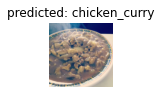

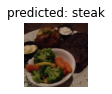

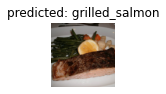

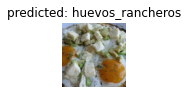

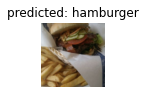

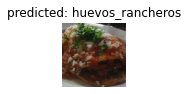

In [51]:
visualize_model(model_ft)

In [52]:
### Free all layers except the final one

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
### Train and evaluate

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

### Saving the model
MODEL_PATH = 'isia_model.pth' 
torch.save(model_conv, MODEL_PATH)

In [ ]:
### Visualize

visualize_model(model_conv)

plt.ioff()
plt.show()